**Soal 1**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('police.csv')

df['stop_datetime'] = pd.to_datetime(df['stop_date'] + ' ' + df['stop_time'])

df.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_datetime
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,2005-01-04 12:55:00
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,2005-01-23 23:15:00
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,2005-02-17 04:15:00
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,2005-02-20 17:15:00
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,2005-02-24 01:20:00


In [12]:
proporsi_pelanggaran = df['driver_gender'].value_counts(normalize=True)

print(proporsi_pelanggaran)

driver_gender
M    0.72527
F    0.27473
Name: proportion, dtype: float64


In [22]:
violation_by_gender = df.groupby(['driver_gender', 'violation']).size() / df.groupby('driver_gender').size()

print(violation_by_gender.sort_values(ascending=False))

driver_gender  violation          
F              Speeding               0.658114
M              Speeding               0.522243
               Moving violation       0.206144
F              Moving violation       0.138218
M              Equipment              0.134158
F              Equipment              0.105199
M              Other                  0.058985
F              Registration/plates    0.044418
M              Registration/plates    0.042175
               Seat belt              0.036296
F              Other                  0.029738
               Seat belt              0.024312
dtype: float64


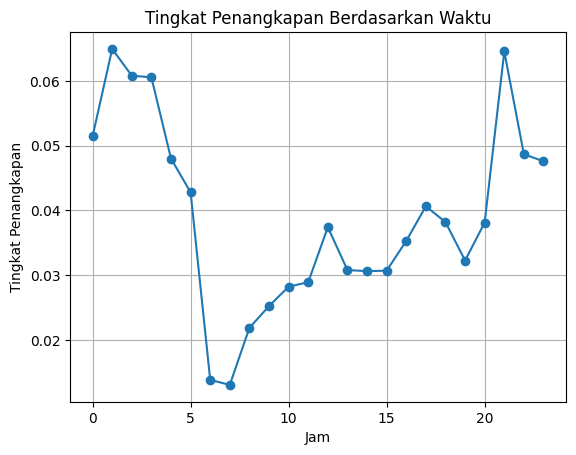

In [30]:
df['hour'] = df['stop_datetime'].dt.hour
arrest_rate_per_hour = df.groupby('hour')['is_arrested'].mean()

plt.plot(arrest_rate_per_hour, marker='o')
plt.title('Tingkat Penangkapan Berdasarkan Waktu')
plt.xlabel('Jam')
plt.ylabel('Tingkat Penangkapan')
plt.grid(True)
plt.show()

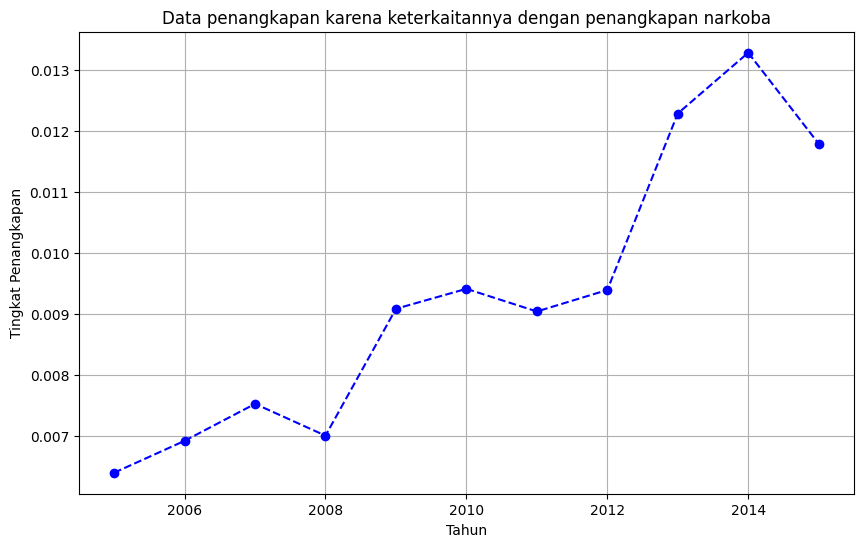

In [27]:
data_narcotics = df.loc[df['drugs_related_stop'] == True].copy()

data_narcotics['stop_date'] = pd.to_datetime(data_narcotics['stop_date'])
df['stop_date'] = pd.to_datetime(df['stop_date'])

narcotics_arrest_rate = data_narcotics.groupby(data_narcotics['stop_date'].dt.year).size() / df.groupby(df['stop_date'].dt.year).size()

plt.figure(figsize=(10, 6))
plt.plot(narcotics_arrest_rate.index, narcotics_arrest_rate.values, marker='o', linestyle='--', color='b')
plt.title('Data penangkapan karena keterkaitannya dengan penangkapan narkoba')
plt.xlabel('Tahun')
plt.ylabel('Tingkat Penangkapan')
plt.grid(True)
plt.show()

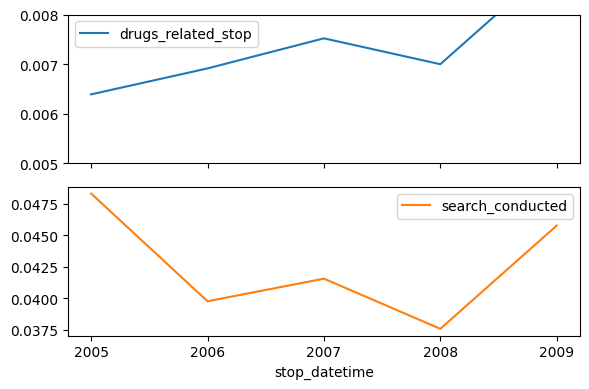

In [29]:
df_filtered = df[df['stop_datetime'].dt.year.between(2005, 2009)].copy()
df_filtered['year'] = df_filtered['stop_datetime'].dt.year

summary = df_filtered.groupby('year').agg({
    'drugs_related_stop': 'mean',
    'search_conducted': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

axes[0].plot(summary['year'], summary['drugs_related_stop'], label='drugs_related_stop', color='tab:blue')
axes[0].legend()
axes[0].set_ylim(0.005, 0.008)

axes[1].plot(summary['year'], summary['search_conducted'], label='search_conducted', color='tab:orange')
axes[1].legend()

axes[1].set_xticks(summary['year'])
axes[1].set_xticklabels(summary['year'])

plt.xlabel('stop_datetime')
plt.tight_layout()
plt.show()


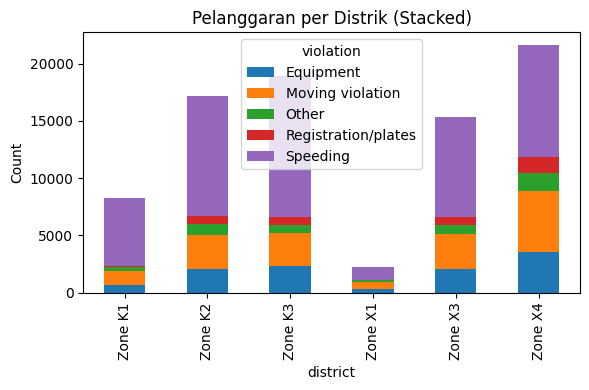

In [43]:
target_violations = ['Equipment', 'Moving violation', 'Other', 'Registration/plates', 'Speeding']
df_filtered = df[df['violation'].isin(target_violations)].dropna(subset=['violation', 'district'])

violation_counts = df_filtered.groupby(['district', 'violation']).size().unstack(fill_value=0)

violation_counts = violation_counts[target_violations]

colors = {
    'Equipment': '#1f77b4',
    'Moving violation': '#ff7f0e',
    'Other': '#2ca02c',
    'Registration/plates': '#d62728',
    'Speeding': '#9467bd'
}

fig, ax = plt.subplots(figsize=(6, 4))
violation_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[colors[col] for col in violation_counts.columns]
)

plt.xlabel('district')
plt.ylabel('Count')
plt.title('Pelanggaran per Distrik (Stacked)')
plt.legend(title='violation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Soal 2**

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [47]:
advertising = pd.read_csv("testcpns.csv")
advertising

,toefl,ipk,pengalaman_kerja,diterima
0,780,4.00,3,1
1,750,3.09,4,1
2,690,3.03,3,0
3,710,3.07,5,1
4,680,3.09,4,0
5,730,3.07,6,1
6,690,2.03,1,0
7,720,3.03,4,1
8,740,3.03,5,1
9,690,1.07,1,0


In [48]:
advertising.describe()

,toefl,ipk,pengalaman_kerja,diterima
count,40.000000,40.000000,40.000000,40.000000
mean,654.000000,2.694500,3.425000,0.475000
std,61.427464,0.653899,1.737778,0.505736
min,540.000000,1.070000,1.000000,0.000000
25%,607.500000,2.070000,2.000000,0.000000
50%,660.000000,3.030000,4.000000,0.000000
75%,690.000000,3.070000,5.000000,1.000000
max,780.000000,4.000000,6.000000,1.000000


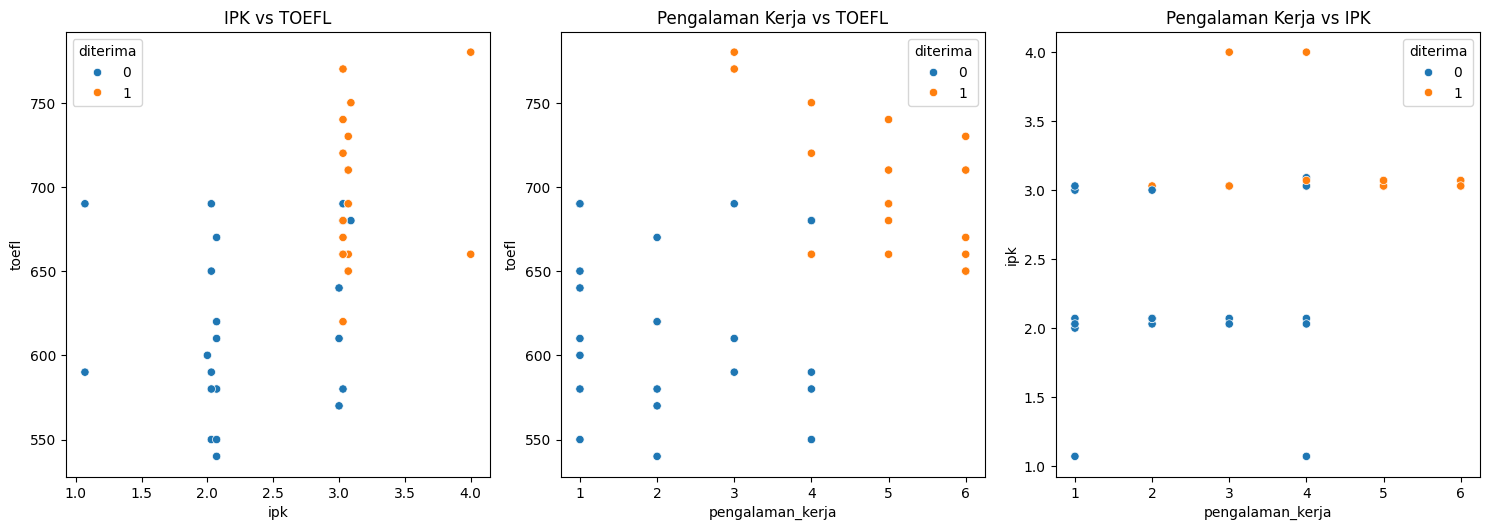

In [49]:
df = pd.read_csv('testcpns.csv')

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='ipk', y='toefl', hue='diterima')
plt.title('IPK vs TOEFL')

plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='pengalaman_kerja', y='toefl', hue='diterima')
plt.title('Pengalaman Kerja vs TOEFL')


plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='pengalaman_kerja', y='ipk', hue='diterima')
plt.title('Pengalaman Kerja vs IPK')

plt.tight_layout()
plt.show()

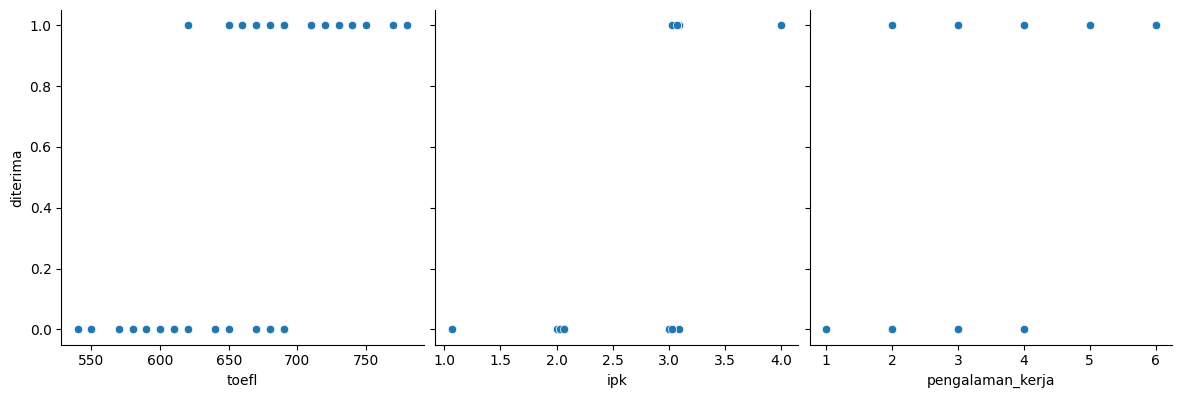

In [50]:
sns.pairplot(advertising,
             x_vars=['toefl', 'ipk', 'pengalaman_kerja'],
             y_vars='diterima',
             height=4,
             aspect=1,
             kind='scatter')

plt.show()

<Figure size 600x500 with 0 Axes>

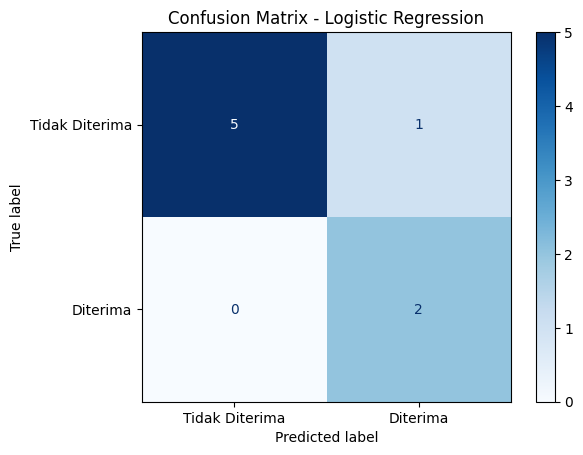

=== Classification Report ===
                precision    recall  f1-score   support

Tidak Diterima       1.00      0.83      0.91         6
      Diterima       0.67      1.00      0.80         2

      accuracy                           0.88         8
     macro avg       0.83      0.92      0.85         8
  weighted avg       0.92      0.88      0.88         8



In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

X = df[['toefl', 'ipk', 'pengalaman_kerja']]
y = df['diterima']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak Diterima", "Diterima"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Tidak Diterima", "Diterima"]))


In [55]:
subset_index = [22, 20, 25, 4, 10, 15, 28, 11, 18, 29, 27, 35]
subset = df.loc[subset_index, :]


print("=== Subset Data ===")
print(subset.to_string(index=False))

=== Subset Data ===
 toefl  ipk  pengalaman_kerja  diterima
   550 2.03                 4         0
   620 3.03                 2         1
   670 3.03                 6         1
   680 3.09                 4         0
   610 2.07                 3         0
   610 3.00                 1         0
   650 3.07                 6         1
   690 3.07                 5         1
   650 3.07                 6         1
   660 3.03                 5         1
   580 2.03                 2         0
   650 2.03                 1         0


In [56]:
data_baru = pd.DataFrame({
    'toefl': [590, 740, 680, 610, 710],
    'ipk': [2, 3.07, 3.03, 2.03, 3],
    'pengalaman_kerja': [3, 4, 6, 1, 5]
})

prediksi = model.predict(data_baru)

for i, hasil in enumerate(prediksi):
    status = "Diterima" if hasil == 1 else "Tidak Diterima"
    print(f"Pelamar {i+1}: {status}")


Pelamar 1: Tidak Diterima
Pelamar 2: Diterima
Pelamar 3: Diterima
Pelamar 4: Tidak Diterima
Pelamar 5: Diterima


In [57]:
X = df[['toefl', 'ipk', 'pengalaman_kerja']]
y = df['diterima']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression().fit(X_train, y_train)

new_data = df.head(10).drop(columns='diterima')

prediksi = model.predict(new_data)


new_data['diterima (prediksi)'] = prediksi
print(new_data)

   toefl   ipk  pengalaman_kerja  diterima (prediksi)
0    780  4.00                 3                    1
1    750  3.09                 4                    1
2    690  3.03                 3                    1
3    710  3.07                 5                    1
4    680  3.09                 4                    1
5    730  3.07                 6                    1
6    690  2.03                 1                    0
7    720  3.03                 4                    1
8    740  3.03                 5                    1
9    690  1.07                 1                    0
